# Sentiment analysis on movie reviews

It is based on this notebook with some modification/extension:

https://www.kaggle.com/code/nilanml/imdb-review-deep-model-94-89-accuracy

In [3]:
import zipfile as zf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_colwidth', 255)

# data cleaning
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

# Keras modules
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt


In [4]:
zips = ['/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip',
       '/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip',
       '/kaggle/input/word2vec-nlp-tutorial/unlabeledTrainData.tsv.zip']

for z in zips:
    with zf.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall('/kaggle/working/')

In [5]:
train_df = pd.read_csv('/kaggle/working/labeledTrainData.tsv', delimiter="\t")
train_df.head()

,id,sentiment,review
0,5814_8,1,"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought..."
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate H. G. Wells' classic book. Mr. Hines succeeds in doing so. I, and those who watched his film with me, ..."
2,7759_3,0,"The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Primal Park . A secret project mutating a primal animal using fossilized DNA, like ¨Jurassik Park¨, and some scientists resurrect one of nature's most fearso..."
3,3630_4,0,"It must be assumed that those who praised this film (\the greatest filmed opera ever,\"" didn't I read somewhere?) either don't care for opera, don't care for Wagner, or don't care about anything except their desire to appear Cultured. Either as a repr..."
4,9495_8,1,"Superbly trashy and wondrously unpretentious 80's exploitation, hooray! The pre-credits opening sequences somewhat give the false impression that we're dealing with a serious and harrowing drama, but you need not fear because barely ten minutes later ..."


In [6]:
# review before cleaning
train_df['review'][9]

'<br /><br />This movie is full of references. Like \\Mad Max II\\", \\"The wild one\\" and many others. The ladybug´s face it´s a clear reference (or tribute) to Peter Lorre. This movie is a masterpiece. We´ll talk much more about in the future."'

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


# Preprocessing

- lemmatisation: correctly identifying the intended part of speech and meaning of a word in a sentence. (e.g.: "better" has a lemma as "good")
- stopwords: list of words that are insignificant to the model

In [8]:
stop_words = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

def clean_text(text):
    # to get rid of html tags and make it lower case:
    text = BeautifulSoup(text, "html.parser").get_text().lower()   
    
    # to get rid of the unnecessary characters eg.: .;\/,*-#<>:()[]{}Łß@
    text = re.sub(r'[^a-z0-9\s]', '', text)    
    
    # lemmatize, remove stopwords
    # 2.param: part of speech tag, "v" for verbs
    text = [wnl.lemmatize(token, "n") for token in text.split(" ")]
    text = [wnl.lemmatize(token, "v") for token in text] 
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    
    return text

In [9]:
train_df['processed_reviews'] = train_df.review.apply(lambda x: clean_text(x))

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [10]:
# after cleaning
train_df.processed_reviews[9]

'movie full reference like mad max ii wild one many others ladybug face clear reference tribute peter lorre movie masterpiece well talk much future'

In [11]:
train_df["text_len"] = train_df.processed_reviews.apply(lambda x: len(x.split(' ')))
max_len = train_df.text_len.max()
print(max_len)

1440


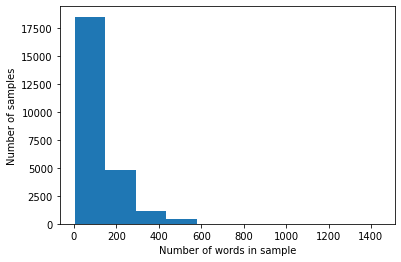

In [12]:
# Histogram to see how the ratios are lining up
plt.hist(train_df.text_len)
plt.xlabel("Number of words in sample")
plt.ylabel("Number of samples")
plt.show()

I pick 400 word as my input parameter, in general it would be telling enough to describe if the comment is positive or negative. Every review with fewer words will be filled with 0. There might be some better approach, but this 400 per sample shouldnt be a problem for the GPU.

In [13]:
max_len = 400

tokenization: substituting certain words with other abstract characters (identifiers), and mapping them back through this system. E.g. used in contraction of two words like: don't, won't.

In [14]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features) # tokenization, num_words: maximum number of words to keep based on their frequency
tokenizer.fit_on_texts(train_df['processed_reviews'])

# convert each word into integers for the model usage (numericalization)
list_tokenized_train = tokenizer.texts_to_sequences(train_df['processed_reviews']) 

In [15]:
# checking numericalized form of reviews
list_tokenized_train[1][:5]

[241, 207, 99, 3156, 5916]

In [16]:
X_t = pad_sequences(list_tokenized_train, max_len) # padding the train data and return 2d np array
y = train_df['sentiment'] # label

In [17]:
# showing padding effect
X_t[1][200:]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  241,  207,   99, 3156, 5916,  276,    3,  449,   13,   31,
        505, 1587, 3373, 2715, 3374,   23,  241,  158,  303, 5916, 1119,
         14,    3,  727,  101,    2,  670,  627,  2

# ML analysis

In [18]:
# train/validation split
x_train, x_val = X_t[:18000], X_t[18000:]
y_train, y_val = y[:18000], y[18000:]

In [19]:
# Model definition
model = Sequential()
model.add(Embedding(max_features, max_len))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(lr=0.00001),
             metrics=['accuracy'])

2023-01-26 15:25:32.188724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 15:25:32.278036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 15:25:32.278874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 15:25:32.281052: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 400)         2400000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         541696    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,368,961
Trainable params: 3,368,961
Non-trainable params: 0
______________________________________________

In [21]:
# Learning rate optimizer
LR_optim = ReduceLROnPlateau(monitor='val_acc', 
                             patience=2, # change after num of epochs 
                             verbose=1,  # update messages
                             factor=0.5, # reduction on lr
                             min_lr=0.01)# limit for the decay

In [22]:
# Training the model
batch_size = 100 
epochs = 10
model.fit(x_train, y_train,
          batch_size=batch_size, 
          epochs=epochs, 
          callbacks=[LR_optim],
          validation_data=(x_val, y_val))

2023-01-26 15:25:35.732590: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-26 15:25:40.624391: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


180/180 [==============================] - 39s 184ms/step - loss: 0.6930 - accuracy: 0.5083 - val_loss: 0.6925 - val_accuracy: 0.5781
Epoch 2/10
180/180 [==============================] - 32s 177ms/step - loss: 0.6919 - accuracy: 0.5577 - val_loss: 0.6911 - val_accuracy: 0.5430
Epoch 3/10
180/180 [==============================] - 31s 171ms/step - loss: 0.6877 - accuracy: 0.6222 - val_loss: 0.6806 - val_accuracy: 0.7157
Epoch 4/10
180/180 [==============================] - 31s 171ms/step - loss: 0.5839 - accuracy: 0.7611 - val_loss: 0.4518 - val_accuracy: 0.8190
Epoch 5/10
180/180 [==============================] - 31s 172ms/step - loss: 0.3876 - accuracy: 0.8446 - val_loss: 0.3785 - val_accuracy: 0.8389
Epoch 6/10
180/180 [==============================] - 32s 178ms/step - loss: 0.3309 - accuracy: 0.8690 - val_loss: 0.3557 - val_accuracy: 0.8521
Epoch 7/10
180/180 [==============================] - 32s 178ms/step - loss: 0.2972 - accuracy: 0.8832 - val_loss: 0.3383 - val_accuracy: 0.8

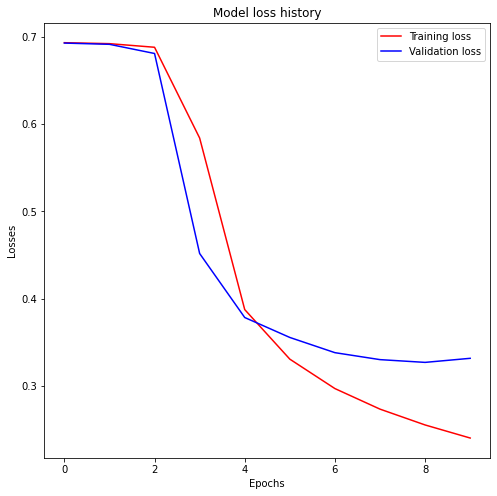

In [23]:
# Training results
fig = plt.figure(figsize=(8,8))
plt.plot(model.history.history['loss'], 'r', label='Training loss')
plt.plot(model.history.history['val_loss'], 'b', label='Validation loss')
plt.title('Model loss history')
plt.ylabel('Losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

After epoch 6 the validation data stops improving (overfitting), so the result of that epoch is the authoritative one.

# Test dataset prediction

In [24]:
test_df = pd.read_csv("/kaggle/working/testData.tsv",header=0, delimiter="\t", quoting=3)
test_df.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of mortality, nostalgia, and loss of innocence it is perhaps not surprising that it is rated more highly by older viewers than younger ones. However there is a craftsmanship and completeness to the film which..."
1,"""8348_2""","""This movie is a disaster within a disaster film. It is full of great action scenes, which are only meaningful if you throw away all sense of reality. Let's see, word to the wise, lava burns you; steam burns you. You can't stand next to lava. Divertin..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw it tonight and my child loved it. At one point my kid's excitement was so great that sitting was impossible. However, I am a great fan of A.A. Milne's books which are very subtle and hide a wry intelligenc..."
3,"""7186_2""","""Afraid of the Dark left me with the impression that several different screenplays were written, all too short for a feature length film, then spliced together clumsily into this Frankenstein's monster.<br /><br />At his best, the protagonist, Lucas, ..."
4,"""12128_7""","""A very accurate depiction of small time mob life filmed in New Jersey. The story, characters and script are believable but the acting drops the ball. Still, it's worth watching, especially for the strong images, some still with me even though I first..."


In [25]:
# apply cleaning on test
test_df["review"] = test_df.review.apply(lambda x: clean_text(x))
 
# extract and binarize id data as sentiment
test_df["sentiment"] = test_df["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)

y_test = test_df["sentiment"] # label

# tokenize, convert to numbers
list_sentences_test = test_df["review"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test) #, maxlen=maxlen)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [26]:
# Predict on test set
prediction = model.predict(X_te)
y_pred = (prediction > 0.5)

In [27]:
# Check results
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')

confusion_matrix(y_pred, y_test)

F1-score: 0.8608741357700239
Confusion matrix:


array([[10913,  1854],
       [ 1587, 10646]])

In [28]:
test_df["prediction"] = y_pred

In [29]:
# To convert y_pred True to 1, False to 0
y_ps = pd.Series(y_pred.flatten(), copy=False).apply(lambda x: 1 if x == True else 0)

# Create prediction column
test_df['prediction'] = y_ps

In [30]:
# Result on first 5 sample
test_df.head()

,id,review,sentiment,prediction
0,"""12311_10""",naturally film main theme mortality nostalgia loss innocence perhaps surprise rat highly older viewer younger one however craftsmanship completeness film anyone enjoy pace steady constant character full engage relationship interaction natural show nee...,1,1
1,"""8348_2""",movie disaster within disaster film full great action scene meaningful throw away sense reality let see word wise lava burn steam burn cant stand next lava divert minor lava flow difficult let alone significant one scare think might actually believe s...,0,0
2,"""5828_4""",movie kid saw tonight child love one point kid excitement wa great sit wa impossible however great fan aa milne book subtle hide wry intelligence behind childlike quality lead character film wa subtle seem shame disney cannot see benefit make movie st...,0,1
3,"""7186_2""",afraid dark leave impression several different screenplay write short feature length film splice together clumsily frankenstein monsterat best protagonist lucas creepy hard draw bead secondary character theyre far sympatheticafraid dark could achieve ...,0,1
4,"""12128_7""",accurate depiction small time mob life film new jersey story character script believable act drop ball still worth watch especially strong image still even though first view 25 year agoa young hood step start bigger thing try thing keep go wrong lead ...,1,1


In [31]:
# Result on all 25k sample
test_df = test_df[test_df['sentiment'] == test_df['prediction']]
test_df.count()

id            21559
review        21559
sentiment     21559
prediction    21559
dtype: int64

So 25.000/21.559 are correctly classified.
Results are not so bad, further improvements could be:
- different model structure,
- parameter tuning
- maybe less than 400 words should be used, because ~100 word is enough to describe an opinion